The task in this notebook is to train a network which, given an image of a star, will calculate both the number of points on the star, as well as its width.

Thus this will be a multi-task network, performing two completely different tasks simultaneously.


In [1]:
#%% import stuff:

import matplotlib.pyplot as plt
import numpy as np
import pickle

import torch
import torch.nn as nn

The cell below assumes you have already downloaded the dataset from brightspace, and put it in your google drive folder. It demonstrates how to use google drive together with a colab notebook.

In [2]:
#from google.colab import drive
#drive.mount('/content/drive')


#temp=pickle.load(open('C:/Users/Jens/Documents/GitHub/DLsolutions/data/starData.p','rb')) # Windows
temp=pickle.load(open('/home/jens/Documents/UNI/9. semester/Deep Learning/DLsolutions/data/starData.p','rb')) # Linux
X=temp['X']
y=temp['y']
#reduce point labels from 3-9 to 0-6 for the net
y[:,0] = y[:,0] - 3 
#device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") #Stationær
device = "cpu" #laptop

print(device)

cpu


torch.Size([1, 100, 100])
tensor([0.0000, 5.4232])


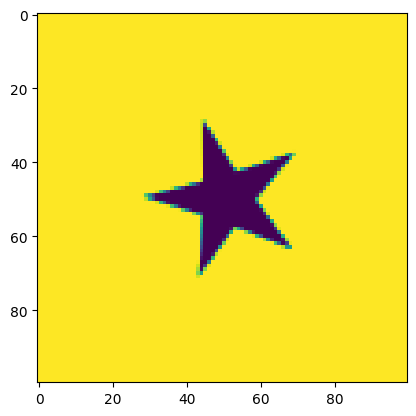

In [3]:
#Let's plot an example

idx=1250
plt.imshow(np.squeeze(X[125,:,:,:],axis=0))
img = X[idx,:,:,:]

print(img.shape)
print(y[idx,:]) #first column is number of points, second is size of the star

In [4]:
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
num_classes = torch.unique(y[:,0]).shape[0]
print(num_classes)

batch_size = 4
#%% make datasets & loaders
dataset = TensorDataset(X, y)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
indices = list(range(len(dataset)))
#split in val and train
x_train, x_temp, y_train, y_temp = train_test_split(X, y, test_size = 0.3, random_state = 42)
x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, test_size = 0.5, random_state = 42)

#make datasets (TensorDataset will do)
#Create subsets of the data using the split indices
train_data = TensorDataset(x_train, y_train)
valid_data = TensorDataset(x_val, y_val)
test_data = TensorDataset(x_test, y_test)


#make dataloaders
train_dl = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=2)
valid_dl = DataLoader(valid_data, batch_size=batch_size, shuffle=True, num_workers=2)
test_dl = DataLoader(test_data, batch_size=batch_size, shuffle=True, num_workers=2)

7


In [5]:
#%% make network
class MTLNet(nn.Module):
 def __init__(self):
     super(MTLNet, self).__init__()
     self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding='same')
     self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding='same')
     
     self.flatten = nn.Flatten()
     self.fc1 = nn.Linear(64*100*100, 512)
     self.fc2 = nn.Linear(512, 128)
     self.relU = nn.ReLU()

     self.fc_points = nn.Linear(128, num_classes)
     self.fc_width = nn.Linear(128, 1)

     
     
 def forward(self,x):
     x = self.conv1(x)
     x = self.relU(x)
     x = self.conv2(x)
     x = self.relU(x)

     x = self.flatten(x)
     
     x = self.fc1(x)
     x = self.relU(x)
     x = self.fc2(x)

     points_out = self.fc_points(x)
     width_out = self.fc_width(x)
     
     return points_out, width_out
#something simple like cnn-cnn-fc-relu-fc will do



#testing:
testData=torch.rand((1,1,100,100)).to(device)
testNet=MTLNet()
testNet.to(device)
testNet.forward(testData)

(tensor([[ 0.0105,  0.0126,  0.0142, -0.0634,  0.0815, -0.0111,  0.0489]],
        grad_fn=<AddmmBackward0>),
 tensor([[0.0399]], grad_fn=<AddmmBackward0>))

In [6]:
#%% define loss'es
loss_classi=nn.CrossEntropyLoss()
loss_regress=nn.MSELoss()
#some combination of losses
loss_fn = lambda x,z,y: (loss_classi(x,(y[:,0]).long()) + loss_regress(z,y[:,1]))

In [9]:
#%% train & validate

nEpoch=20
net=MTLNet()
net.to(device)
optimizer=torch.optim.SGD(net.parameters(),lr=0.01,momentum=0.9)

running_loss = []
validation_loss = []

for iEpoch in range(nEpoch):
    net.train()
    totLoss=0
    num_batches=0
    for xbatch,ybatch in train_dl:
        xbatch=xbatch.to(device)
        ybatch=ybatch.to(device)
        
        points_out, width_out = net(xbatch)
        loss = loss_fn(points_out, width_out, ybatch).to(device)
        loss.backward()
        
        optimizer.step()
        optimizer.zero_grad()
        
        totLoss += loss.item()
        num_batches += 1
        
    avg_loss = totLoss / num_batches
    running_loss.append(avg_loss)
        #the usual. pass the output of your network to the custom loss function you made above
        #use it to update the weights


    net.eval()  # Set model to evaluation mode
    totValLoss = 0
    num_val_batches = 0

    with torch.no_grad():  # Disable gradient computation during validation
        for xbatch, ybatch in valid_dl:
            xbatch = xbatch
            ybatch = ybatch
            
            points_out, width_out = net(xbatch)
            loss = loss_fn(points_out, width_out, ybatch)
            
            totValLoss += loss.item()
            num_val_batches += 1

    avg_val_loss = totValLoss / num_val_batches
    validation_loss.append(avg_val_loss)
    print(f"Epoch [{iEpoch+1}/{nEpoch}] Train Loss: {avg_loss:.4f}, Validation Loss: {avg_val_loss:.4f}")

/home/jens/.local/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([4])) that is different to the input size (torch.Size([4, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [1/20] Train Loss: nan, Validation Loss: nan


KeyboardInterrupt: 

In [ ]:
#evaluate

#try plotting predictions vs. targets for both training data and validation data in a scatterplot, and see how much variation you've captured